In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import tensorflow
print(tensorflow.__version__)
from tensorflow.keras.preprocessing import image
from sklearn.decomposition import PCA
from math import ceil

2.0.0


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# ls /content/drive/'My Drive'/'RMIT PROGRAMMING'/'Machine Learning A2'/

In [5]:
# cd /content/drive/'My Drive'/'RMIT PROGRAMMING'/'Machine Learning A2'/

In [6]:
# ls

In [7]:
# pwd

In [8]:
dfMain = pd.read_csv('Image_classification_data/data_labels_mainData.csv')
dfExtra = pd.read_csv('Image_classification_data/data_labels_extraData.csv')
dfJoined = pd.concat([dfMain, dfExtra])
display(dfJoined)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0.0,0
1,22406,1,22406.png,fibroblast,0.0,0
2,22407,1,22407.png,fibroblast,0.0,0
3,22408,1,22408.png,fibroblast,0.0,0
4,22409,1,22409.png,fibroblast,0.0,0
...,...,...,...,...,...,...
10379,20028,99,20028.png,NaN,NaN,0
10380,20029,99,20029.png,NaN,NaN,0
10381,20030,99,20030.png,NaN,NaN,0
10382,20031,99,20031.png,NaN,NaN,0


In [9]:
dfJoined.shape

(20280, 6)

In [10]:
dfJoined.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0.0,0
1,22406,1,22406.png,fibroblast,0.0,0
2,22407,1,22407.png,fibroblast,0.0,0
3,22408,1,22408.png,fibroblast,0.0,0
4,22409,1,22409.png,fibroblast,0.0,0


In [11]:
dfJoined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20280 entries, 0 to 10383
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   InstanceID    20280 non-null  int64  
 1   patientID     20280 non-null  int64  
 2   ImageName     20280 non-null  object 
 3   cellTypeName  9896 non-null   object 
 4   cellType      9896 non-null   float64
 5   isCancerous   20280 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ MB


In [12]:
dfJoined.describe()

,InstanceID,patientID,cellType,isCancerous
count,20280.000000,20280.000000,9896.000000,20280.000000
mean,11163.660848,55.681065,1.501516,0.348570
std,6481.457867,28.891837,0.954867,0.476529
min,1.000000,1.000000,0.000000,0.000000
25%,5551.750000,29.000000,1.000000,0.000000
50%,11111.500000,63.000000,2.000000,0.000000
75%,16756.250000,81.000000,2.000000,1.000000
max,22444.000000,99.000000,3.000000,1.000000


In [13]:
dfJoined.dtypes

InstanceID        int64
patientID         int64
ImageName        object
cellTypeName     object
cellType        float64
isCancerous       int64
dtype: object

In [14]:
dfJoined.columns

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')

In [15]:
dfJoined.isnull().sum()

InstanceID          0
patientID           0
ImageName           0
cellTypeName    10384
cellType        10384
isCancerous         0
dtype: int64

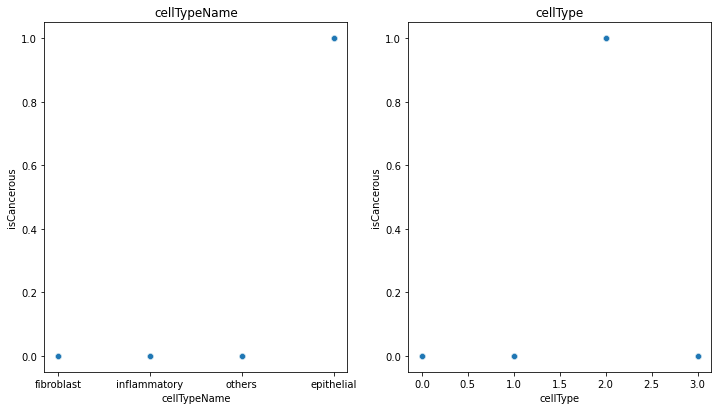

In [16]:
plt.figure(figsize=(25,45))
plt.subplot(6,4,1)
sns.scatterplot(data=dfMain, x=dfMain['cellTypeName'], y='isCancerous')
plt.title('cellTypeName')
plt.xticks(rotation='horizontal')

# Not sure what this is actually showing 
plt.subplot(6,4,2)
sns.scatterplot(data=dfJoined, x=dfJoined['cellType'], y='isCancerous')
plt.title('cellType')
plt.xticks(rotation='horizontal')
plt.show()

<AxesSubplot:xlabel='Is Cancerous'>

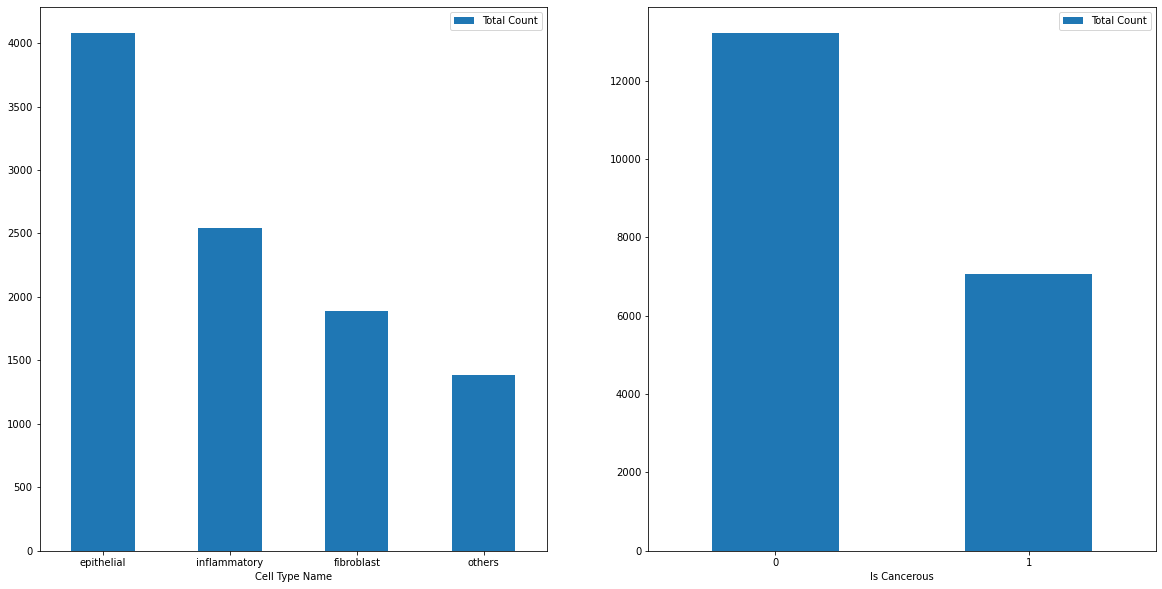

In [17]:
dfCellCounts = pd.DataFrame(dfMain.cellTypeName.value_counts().reset_index().values, columns=['Cell Type Name', 'Total Count'])
dfCancerousCounts = pd.DataFrame(dfJoined.isCancerous.value_counts().reset_index().values, columns=['Is Cancerous', 'Total Count'])
dfPatientImagesCount = pd.DataFrame(dfJoined.patientID.value_counts().reset_index().values, columns=['Patient ID', 'Total Images for Patient'])
dfPatientImagesCount = dfPatientImagesCount.sort_values('Patient ID', ascending=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
dfCellCounts.plot(kind='bar', x='Cell Type Name', y='Total Count', ax=axes[0], rot=0)
dfCancerousCounts.plot(kind='bar', x='Is Cancerous', y='Total Count', ax=axes[1], rot=0)

<AxesSubplot:xlabel='Patient ID'>

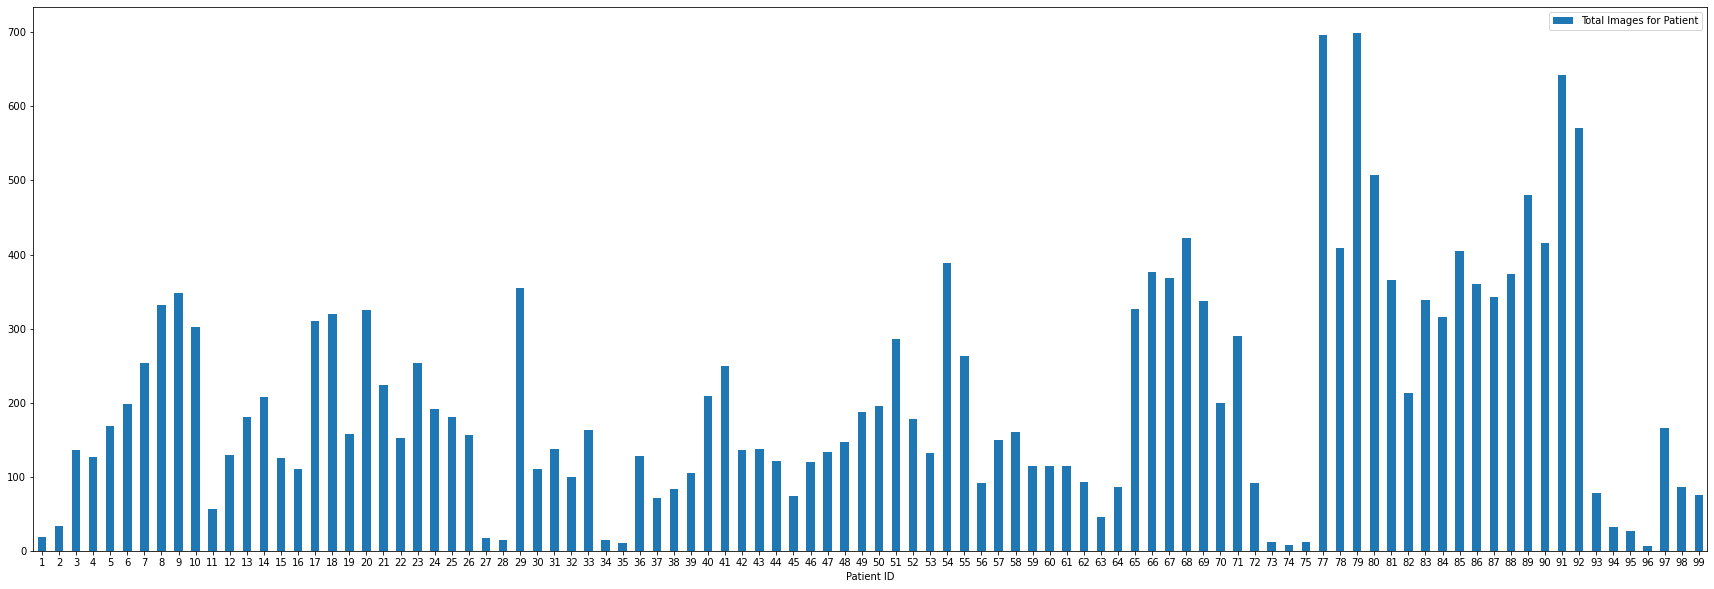

In [18]:
# fig = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
dfPatientImagesCount.plot(kind='bar', x='Patient ID', y='Total Images for Patient', figsize=(30, 10), rot=0)

In [19]:
dfEpithelial = dfMain.loc[dfMain['cellTypeName'] == 'epithelial']
dfInflammatory = dfMain.loc[dfMain['cellTypeName'] == 'inflammatory']
dfFibroblast = dfMain.loc[dfMain['cellTypeName'] == 'fibroblast']
dfOthers= dfMain.loc[dfMain['cellTypeName'] == 'others']

In [20]:
cancerous = dfMain.loc[dfMain['isCancerous'] == 1]
non_cancerous = dfMain.loc[dfMain['isCancerous'] == 0]
print(cancerous.equals(dfEpithelial))

True


In [21]:
### ANDREW's PART ###

In [22]:
path = 'Image_classification_data/patch_images/' # image folder

In [23]:
dfIsCancerous = dfJoined.loc[dfJoined['isCancerous'] == 1]
print(dfIsCancerous)

      InstanceID  patientID ImageName cellTypeName  cellType  isCancerous
449          276          5   276.png   epithelial       2.0            1
450          277          5   277.png   epithelial       2.0            1
451          278          5   278.png   epithelial       2.0            1
452          279          5   279.png   epithelial       2.0            1
453          280          5   280.png   epithelial       2.0            1
...          ...        ...       ...          ...       ...          ...
7800        7667         88  7667.png          NaN       NaN            1
7801        7668         88  7668.png          NaN       NaN            1
7802        7669         88  7669.png          NaN       NaN            1
7803        7670         88  7670.png          NaN       NaN            1
7804        7671         88  7671.png          NaN       NaN            1

[7069 rows x 6 columns]


In [24]:
dfNotCancerous = dfJoined.loc[dfJoined['isCancerous'] == 0]
print(dfNotCancerous)

       InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0           22405          1  22405.png   fibroblast       0.0            0
1           22406          1  22406.png   fibroblast       0.0            0
2           22407          1  22407.png   fibroblast       0.0            0
3           22408          1  22408.png   fibroblast       0.0            0
4           22409          1  22409.png   fibroblast       0.0            0
...           ...        ...        ...          ...       ...          ...
10379       20028         99  20028.png          NaN       NaN            0
10380       20029         99  20029.png          NaN       NaN            0
10381       20030         99  20030.png          NaN       NaN            0
10382       20031         99  20031.png          NaN       NaN            0
10383       20032         99  20032.png          NaN       NaN            0

[13211 rows x 6 columns]


In [25]:
nonCancerous = dfNotCancerous['ImageName'].tolist()
isCancerous = dfIsCancerous['ImageName'].tolist()

In [26]:
# randomly select 10 of each image from non-cancerous and cancerous lists
select_nonCancerous = np.random.choice(nonCancerous, 10, replace = False)
select_isCancerous = np.random.choice(isCancerous, 10, replace = False)

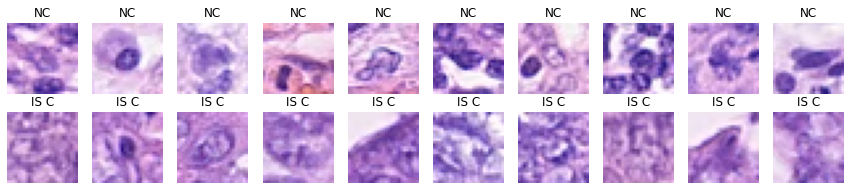

In [27]:
fig = plt.figure(figsize = (15,3))
rows = 2
columns = 12

for i in range(20):
    if i < 10:
        fp = path + select_nonCancerous[i]
        label = 'NC'
    else:
        fp = path + select_isCancerous[i-10]
        label = 'IS C'
        
    ax = fig.add_subplot(2, 10, i+1)
    fn = image.load_img(fp)
    plt.imshow(fn)
    plt.title(label)
    plt.axis('off')
plt.show()

In [28]:
epithelial = dfEpithelial['ImageName'].tolist()
inflammatory = dfInflammatory['ImageName'].tolist()
fibroblast = dfFibroblast['ImageName'].tolist()
others= dfOthers['ImageName'].tolist()

# # randomly select 10 of each image from each cell type name
selectEpithelial = np.random.choice(epithelial, 10, replace = False)
selectInflammatory = np.random.choice(inflammatory, 10, replace = False)
selectFibroblast = np.random.choice(fibroblast, 10, replace = False)
selectOthers = np.random.choice(others, 10, replace = False)

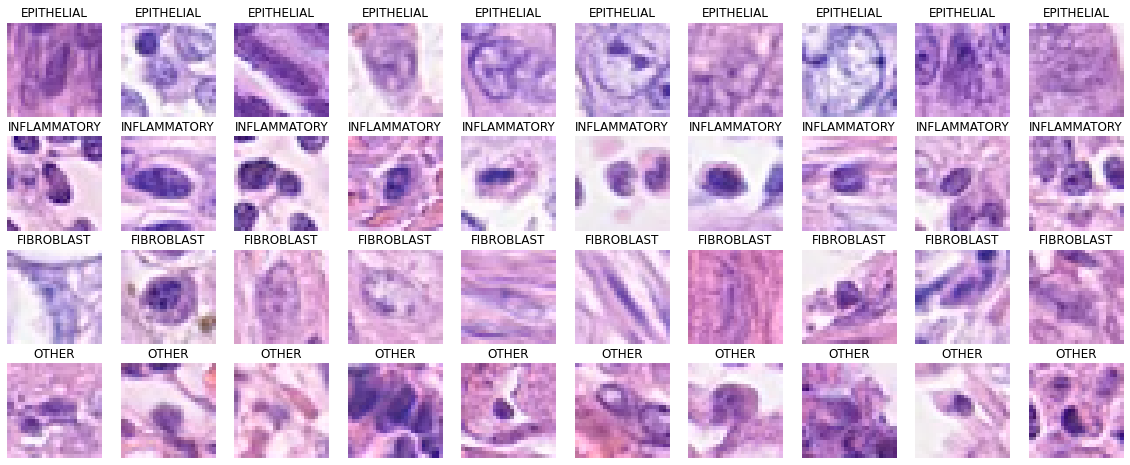

In [29]:
fig = plt.figure(figsize = (20,8))
rows = 4
columns = 12

for i in range(40):
    if i < 10:
        fp = path + selectEpithelial[i]
        label = 'EPITHELIAL'
    elif i < 20 :
        fp = path + selectInflammatory[i-10]
        label = 'INFLAMMATORY'
    elif i < 30 :
        fp = path + selectFibroblast[i-20]
        label = 'FIBROBLAST'
    elif i < 40 :
        fp = path + selectOthers[i-30]
        label = 'OTHER'
        
    ax = fig.add_subplot(4, 10, i+1)
    fn = image.load_img(fp)
    plt.imshow(fn)
    plt.title(label)
    plt.axis('off')
plt.show()

In [30]:
def image2Matrix(path, listOfFiles, size = (27,27)):
    for file in listOfFiles:
        filePath = path + file
        currentImage = image.load_img(filePath, target_size=size, color_mode='grayscale')
        
        image_matrix = image.img_to_array(currentImage)
        image_matrix = [image_matrix.ravel()]
        
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, image_matrix))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = image_matrix
    return full_mat

nonCancerousImages = image2Matrix(path, nonCancerous)
isCancerousImages = image2Matrix(path, isCancerous)
# isCancerousImages = image2Matrix(path, isCancerous)

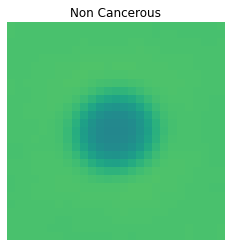

In [31]:
def averageImage(full_mat, title, size = (27,27)):
    
    meanImage = np.mean(full_mat, axis = 0)
    meanImage = meanImage.reshape(size)
    plt.imshow(meanImage, vmin=0, vmax=255, cmap='viridis')
    plt.title(title)
    plt.axis('off')
    return meanImage

nonCancerousMean = averageImage(nonCancerousImages, 'Non Cancerous')

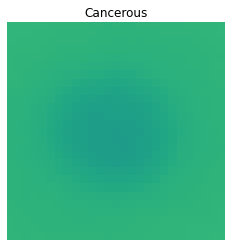

In [32]:
isCancerousMean = averageImage(isCancerousImages, 'Cancerous')

In [33]:
# def averageImage(axes, full_mat, title, size = (27,27)):
#     fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
#     meanImage = np.mean(full_mat, axis = 0)
#     meanImage = meanImage.reshape(size)
    
#     if axes == 1:
#         ax1.imshow(meanImage, vmin=0, vmax=255, cmap='viridis')
#         ax1.set_title(title)
#         ax1.axis('off')
#     else:
#         ax2.imshow(meanImage, vmin=0, vmax=255, cmap='viridis')
#         ax2.set_title(title)
#         ax2.axis('off')
#     return meanImage



# nonCancerousMean = averageImage(1, nonCancerousImages, 'Non Cancerous')
# isCancerousMean = averageImage(2, isCancerousImages, 'Cancerous')

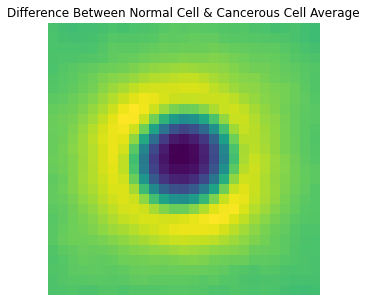

In [34]:
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
contrast_mean = nonCancerousMean - isCancerousMean
plt.imshow(contrast_mean, cmap='viridis')
plt.title(f'Difference Between Normal Cell & Cancerous Cell Average')
plt.axis('off')
plt.show()

In [35]:
from sklearn.model_selection import train_test_split

with pd.option_context('mode.chained_assignment', None):
    train_data_, test_data = train_test_split(dfMain, test_size=0.2, 
                                              shuffle=True,random_state=0)
    
with pd.option_context('mode.chained_assignment', None):
    train_data, val_data = train_test_split(train_data_, test_size=0.25, 
                                            shuffle=True,random_state=0)
    
print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [36]:
train_X = train_data.drop(['isCancerous',], axis=1).to_numpy()
train_y = train_data[['isCancerous']].to_numpy()

test_X = test_data.drop(['isCancerous',], axis=1).to_numpy()
test_y = test_data[['isCancerous']].to_numpy()

val_X = val_data.drop(['isCancerous',], axis=1).to_numpy()
val_y = val_data[['isCancerous']].to_numpy()

In [38]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [39]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [40]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


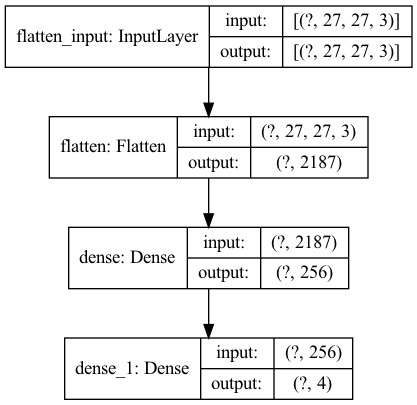

In [42]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [43]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
train_data['Class'] = train_data['Class'].astype('str')
val_data['Class'] = val_data['Class'].astype('str')

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')


Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [54]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

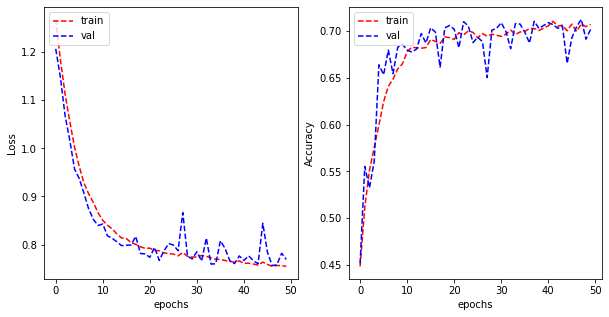

In [55]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [57]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


/Users/kashyap/opt/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
model.evaluate(test_generator)

1980/1980 [==============================] - 3s 2ms/step - loss: 0.8076 - categorical_accuracy: 0.6904


[0.8075766535634599, 0.69040406]

In [59]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

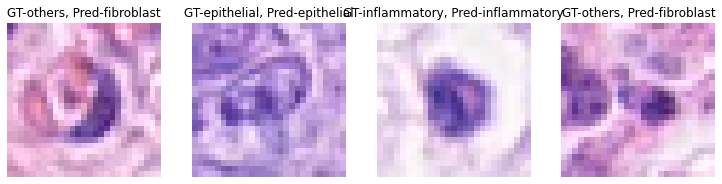

In [60]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')